### Book and Bill Exploratory Data Analysis

Author: Syamanthaka Balakrishnan

Created: June 2019

------------------------------------------------------------------------------------------------

#### Notes
* The main input source is One Order Book data for Ultra Sound. 
* Extract the closed orders and first tag them as BnB or funnel.
* Map description with materiarl master information to tag as system or upgrade and category
* Map and convert local currency to USD using AOP info
* Report percentage of orders which are BnB
* Report by product
* Report by Quarter

## Section 1 - Classify book and billed
### 1.1 Data preparation
#### Import libraries required

In [1]:
import pandas as pd
import numpy as np
from datetime import datetime as dt
import matplotlib.pyplot as plt
from matplotlib_venn import venn2
from matplotlib.ticker import PercentFormatter

#### Read input, get closed orders

In [2]:
sap_df = pd.read_csv("OOB_cleaned_1819.csv", encoding='iso-8859-1', low_memory=False)
sap_df.rename(columns=lambda x: x.strip(), inplace=True)
sap_df = sap_df[['BMC Market', 'Comp_code_Sales', 'Country', 'Sold-to_party', 'Description', 'Sales order', 'First Fin Bill Date',
                 'Local Currency', 'Creation date', 'Total OIT Value (DC)']]
sap_df = sap_df[sap_df['First Fin Bill Date'] != "#"] 
sap_df.head()

,BMC Market,Comp_code_Sales,Country,Sold-to_party,Description,Sales order,First Fin Bill Date,Local Currency,Creation date,Total OIT Value (DC)
0,Africa,H0_EG90,EGYPT LLC,???? ????? ????????,AFFINITI 50 ULTRASOUND SYSTEM,H0_6600378541,5/2/2018,USD,1/31/2018,48000
2,Africa,H0_ZA91,SOUTH AFRICA,Mediclinic Bloemfontein,CLEARVUE 550 ULTRASOUND SYSTEM,H0_6600376487,3/28/2018,ZAR,12/7/2017,-0.01
4,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,AFFINITI 70 UPGRADE,H0_6600376874,3/29/2018,ZAR,1/22/2018,196240
5,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,CLEARVUE 650 ULTRASOUND SYSTEM,H0_6600380813,3/29/2018,ZAR,1/29/2018,278000
7,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,QLAB,H0_6600376873,2/28/2018,ZAR,1/22/2018,23460


#### Ignoring ambiguous currencies for now

In [3]:
## More work arounds for now
print("Rows which have ambigous currency " + str(len(sap_df[sap_df['Local Currency'] == "#"])))
print("Total rows in data set " + str(len(sap_df)))
sap_df = sap_df[sap_df['Local Currency'] != "#"]
print("Rows after ambiguous currency cleanup " + str(len(sap_df)))

Rows which have ambigous currency 2599
Total rows in data set 72349
Rows after ambiguous currency cleanup 69750


In [ ]:
sap_df['Local Currency'].unique()

#### Collection of functions required

In [4]:
## Function to check if for given year, order creation and billing date are in same quarter, tag it as BnB.
def check_quarter(row):
    order_create = row['Creation date']
    billing = row['First Fin Bill Date']
    
    order_create_date = dt.strptime(order_create, '%m/%d/%Y').date()
    billing_date = dt.strptime(billing, '%m/%d/%Y').date()
    
    ord_yr = order_create_date.year
    bill_yr = billing_date.year
    
    ord_mnt = order_create_date.month
    bill_mnt = billing_date.month
    
    ord_q = (ord_mnt - 1)//3 + 1
    bill_q = (bill_mnt - 1)//3 + 1
    
    bnb_flag = "BnB" if ((ord_yr == bill_yr) & (ord_q == bill_q)) else "Non_BnB"  
    return (bnb_flag)


#### Classifying each row as BnB or Non_BnB

In [5]:
sap_df['Bnb_flag'] = sap_df.apply(check_quarter, axis=1)
sap_df.head()

,BMC Market,Comp_code_Sales,Country,Sold-to_party,Description,Sales order,First Fin Bill Date,Local Currency,Creation date,Total OIT Value (DC),Bnb_flag
0,Africa,H0_EG90,EGYPT LLC,???? ????? ????????,AFFINITI 50 ULTRASOUND SYSTEM,H0_6600378541,5/2/2018,USD,1/31/2018,48000,Non_BnB
2,Africa,H0_ZA91,SOUTH AFRICA,Mediclinic Bloemfontein,CLEARVUE 550 ULTRASOUND SYSTEM,H0_6600376487,3/28/2018,ZAR,12/7/2017,-0.01,Non_BnB
4,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,AFFINITI 70 UPGRADE,H0_6600376874,3/29/2018,ZAR,1/22/2018,196240,BnB
5,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,CLEARVUE 650 ULTRASOUND SYSTEM,H0_6600380813,3/29/2018,ZAR,1/29/2018,278000,BnB
7,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,QLAB,H0_6600376873,2/28/2018,ZAR,1/22/2018,23460,BnB


#### Map description with system type and category

In [6]:
material_master = pd.read_excel("Description_master_Data.xlsx", sheet_name="Mapping")
material_master.head()

sap_df = pd.merge(sap_df, material_master, on='Description', how='left')
sap_df.head()

,BMC Market,Comp_code_Sales,Country,Sold-to_party,Description,Sales order,First Fin Bill Date,Local Currency,Creation date,Total OIT Value (DC),Bnb_flag,System,Category
0,Africa,H0_EG90,EGYPT LLC,???? ????? ????????,AFFINITI 50 ULTRASOUND SYSTEM,H0_6600378541,5/2/2018,USD,1/31/2018,48000,Non_BnB,System,Affiniti
1,Africa,H0_ZA91,SOUTH AFRICA,Mediclinic Bloemfontein,CLEARVUE 550 ULTRASOUND SYSTEM,H0_6600376487,3/28/2018,ZAR,12/7/2017,-0.01,Non_BnB,System,Clearvue
2,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,AFFINITI 70 UPGRADE,H0_6600376874,3/29/2018,ZAR,1/22/2018,196240,BnB,Upgrade,Affiniti
3,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,CLEARVUE 650 ULTRASOUND SYSTEM,H0_6600380813,3/29/2018,ZAR,1/29/2018,278000,BnB,System,Clearvue
4,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,QLAB,H0_6600376873,2/28/2018,ZAR,1/22/2018,23460,BnB,Others,Others


#### Map Local currencies with AOP and convert OIT value to USD

In [7]:
aop_df = pd.read_excel("AOP rates Aug-18.xlsx", sheet_name="Sheet2")
aop_df = aop_df[['Currency', 'USD']]
aop_df.head()

sap_df = pd.merge(sap_df, aop_df, left_on='Local Currency', right_on='Currency', how='left')
sap_df = sap_df.drop(['Currency'], axis=1)
sap_df['Total OIT Value (DC)'] = pd.to_numeric(sap_df['Total OIT Value (DC)'], errors='coerce')
sap_df['Val_USD'] = round(sap_df['Total OIT Value (DC)'], 2) * round(sap_df['USD'], 2)
sap_df.head()

,BMC Market,Comp_code_Sales,Country,Sold-to_party,Description,Sales order,First Fin Bill Date,Local Currency,Creation date,Total OIT Value (DC),Bnb_flag,System,Category,USD,Val_USD
0,Africa,H0_EG90,EGYPT LLC,???? ????? ????????,AFFINITI 50 ULTRASOUND SYSTEM,H0_6600378541,5/2/2018,USD,1/31/2018,48000.00,Non_BnB,System,Affiniti,1.000000,48000.0000
1,Africa,H0_ZA91,SOUTH AFRICA,Mediclinic Bloemfontein,CLEARVUE 550 ULTRASOUND SYSTEM,H0_6600376487,3/28/2018,ZAR,12/7/2017,-0.01,Non_BnB,System,Clearvue,0.069324,-0.0007
2,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,AFFINITI 70 UPGRADE,H0_6600376874,3/29/2018,ZAR,1/22/2018,196240.00,BnB,Upgrade,Affiniti,0.069324,13736.8000
3,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,CLEARVUE 650 ULTRASOUND SYSTEM,H0_6600380813,3/29/2018,ZAR,1/29/2018,278000.00,BnB,System,Clearvue,0.069324,19460.0000
4,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,QLAB,H0_6600376873,2/28/2018,ZAR,1/22/2018,23460.00,BnB,Others,Others,0.069324,1642.2000


In [9]:
sap_df['Creation date'] = sap_df['Creation date'].astype('datetime64[D]')
sap_df['year'] = sap_df['Creation date'].dt.year
sap_df['quarter'] = sap_df['Creation date'].dt.quarter

In [10]:
sap_df = sap_df[sap_df['year'] != 2017]
sap_df.head()

,BMC Market,Comp_code_Sales,Country,Sold-to_party,Description,Sales order,First Fin Bill Date,Local Currency,Creation date,Total OIT Value (DC),Bnb_flag,System,Category,USD,Val_USD,year,quarter
0,Africa,H0_EG90,EGYPT LLC,???? ????? ????????,AFFINITI 50 ULTRASOUND SYSTEM,H0_6600378541,5/2/2018,USD,2018-01-31,48000.0,Non_BnB,System,Affiniti,1.000000,48000.0,2018,1
2,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,AFFINITI 70 UPGRADE,H0_6600376874,3/29/2018,ZAR,2018-01-22,196240.0,BnB,Upgrade,Affiniti,0.069324,13736.8,2018,1
3,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,CLEARVUE 650 ULTRASOUND SYSTEM,H0_6600380813,3/29/2018,ZAR,2018-01-29,278000.0,BnB,System,Clearvue,0.069324,19460.0,2018,1
4,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,QLAB,H0_6600376873,2/28/2018,ZAR,2018-01-22,23460.0,BnB,Others,Others,0.069324,1642.2,2018,1
5,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,CX50 ULTRASOUND SYSTEM,H0_6600376873,2/28/2018,ZAR,2018-01-22,725010.0,BnB,System,CX50,0.069324,50750.7,2018,1


### 1.2 Pie Charts for proportion of BnB vs Non_BnB 
#### 2018-2019

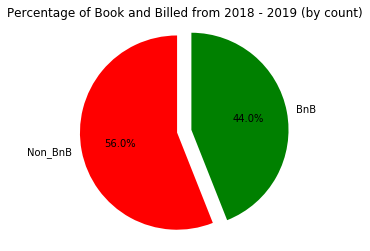

In [25]:
bnb_pct = round(100 * sap_df['Bnb_flag'].value_counts(normalize=True))
bnb_pct.plot.pie(y=bnb_pct.index,
           shadow=False,
           colors=['red', 'green'], 
           explode=(0, 0.15),   # exploding 'Bnb'
           startangle=90,
           autopct='%1.1f%%')

plt.axis('equal')
plt.ylabel('')
plt.title('Percentage of Book and Billed from 2018 - 2019 (by count)')

plt.savefig(r"C:\Users\320054667\OneDrive - Philips\Work\Project\UltraSound\BookNBill\Graphs\BnB1819_by_count.png")
plt.show()

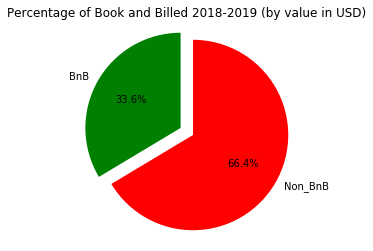

In [33]:
pct_val_all = (sap_df.groupby('Bnb_flag')['Val_USD'].sum()/ sap_df['Val_USD'].sum()) * 100
pct_val_all.plot.pie(y=pct_val_all.index,
       shadow=False,
       colors=['green', 'red'], 
       explode=(0, 0.15),   # exploding 'Bnb'
       startangle=90,
       autopct='%1.1f%%')

plt.axis('equal')

plt.ylabel('')
plt.title('Percentage of Book and Billed 2018-2019 (by value in USD)')

plt.savefig(r"C:\Users\320054667\OneDrive - Philips\Work\Project\UltraSound\BookNBill\Graphs\BnB1819_by_valUSD.png")
plt.show()

In [13]:
df2018 = sap_df[sap_df['year'] == 2018]
df2019 = sap_df[sap_df['year'] == 2019]

#### 2018

In [ ]:
pct2018 = round(100 * df2018['Bnb_flag'].value_counts(normalize=True))
pct2018.plot.pie(y=pct2018.index,
       shadow=False,
       colors=['red', 'green'], 
       explode=(0, 0.15),   # exploding 'Bnb'
       startangle=90,
       autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.ylabel('')
plt.title('Percentage of Book and Billed in 2018 (by count)')
plt.show()


In [ ]:
pct_val2018 = (df2018.groupby('Bnb_flag')['Val_USD'].sum()/ df2018['Val_USD'].sum()) * 100
pct_val2018.plot.pie(y=pct_val2018.index,
       shadow=False,
       colors=['green', 'red'], 
       explode=(0, 0.15),   # exploding 'Bnb'
       startangle=90,
       autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.ylabel('')
plt.title('Percentage of Book and Billed in 2018 (by value USD)')
plt.show()

#### 2019

In [ ]:
pct2019 = round(100 * df2019['Bnb_flag'].value_counts(normalize=True))
pct2019.plot.pie(y=pct2019.index,
       shadow=False,
       colors=['red', 'green'], 
       explode=(0, 0.15),   # exploding 'Bnb'
       startangle=90,
       autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.ylabel('')
plt.title('Percentage of Book and Billed in 2019 (by count)')
plt.show()


In [ ]:
pct_val2019 = (df2019.groupby('Bnb_flag')['Val_USD'].sum()/ df2019['Val_USD'].sum()) * 100
pct_val2019.plot.pie(y=pct_val2019.index,
       shadow=False,
       colors=['green', 'red'], 
       explode=(0, 0.15),   # exploding 'Bnb'
       startangle=90,
       autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.ylabel('')
plt.title('Percentage of Book and Billed in 2019 (by value USD)')
plt.show()

### 1.3 Line Graphs for BnB vs Non_BnB trends over time (Y, Q)
#### Overall trend 2018 - 2019

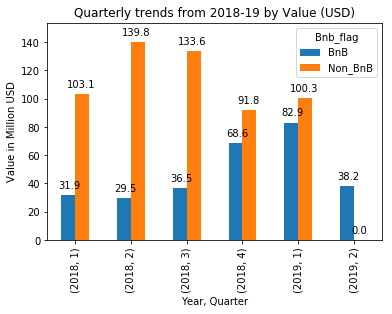

In [59]:
val_trends_bar = sap_df.groupby(['year', 'quarter', 'Bnb_flag'])['Val_USD'].sum() / 1000000
val_trends_bar_df = val_trends_bar.unstack('Bnb_flag')

ax = val_trends_bar_df.plot(kind='bar')
def autolabel(rects, ax):
    for rect in rects:
        x = round(rect.get_x() + rect.get_width()/2., 1)
        y = round(rect.get_height(), 1)
        ax.annotate("{}".format(y), (x,y), xytext=(0,5), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax.patches,ax)

ax.margins(y=0.1)

plt.title('Quarterly trends from 2018-19 by Value (USD)')
plt.xlabel('Year, Quarter')
plt.ylabel('Value in Million USD')
plt.savefig(r"C:\Users\320054667\OneDrive - Philips\Work\Project\UltraSound\BookNBill\Graphs\Quarterly_trends_both.png")

plt.show()

In [66]:
val_trends_bar_df['Total'] = val_trends_bar_df['BnB'] + val_trends_bar_df['Non_BnB']
val_trends_bar_df['Bnb_pct'] = (val_trends_bar_df['BnB'] / val_trends_bar_df['Total']) * 100
val_trends_bar_df.head()

Bnb_flag            BnB     Non_BnB       Total    Bnb_pct
year quarter                                              
2018 1        31.866965  103.127549  134.994515  23.606119
     2        29.542210  139.781822  169.324033  17.447145
     3        36.527755  133.646314  170.174069  21.464936
     4        68.620746   91.762641  160.383387  42.785445
2019 1        82.904453  100.273005  183.177458  45.259091

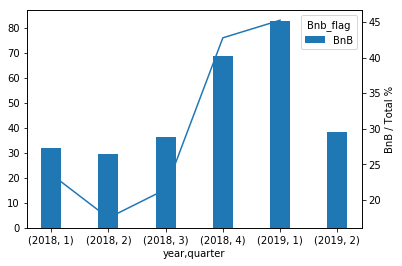

In [75]:
#m1_t[['abnormal','fix','normal']].plot(kind='bar', width = width)
width=0.35
val_trends_bar_df[['BnB']].plot(kind='bar', width=width)
val_trends_bar_df['Bnb_pct'].plot(secondary_y=True, label='Total')
#m1_t['bad_rate'].plot(secondary_y=True)

ax = plt.gca()

ax.set_ylabel('BnB / Total %')
#ax.ylabel('Value in Million USD')
#ax.right_ax.set_ylabel('Average age')
#ax.set_xticklabels(('G1', 'G2', 'G3', 'G4', 'G5', 'G6', 'G7', 'G8', 'G9', 'G10'))

plt.show()

# ax = val_trends_bar_df.plot(kind='bar')
def autolabel(rects, ax):
    for rect in rects:
        x = round(rect.get_x() + rect.get_width()/2., 1)
        y = round(rect.get_height(), 1)
        ax.annotate("{}".format(y), (x,y), xytext=(0,5), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax.patches,ax)

# ax.margins(y=0.1)

# plt.title('Quarterly trends from 2018-19 by Value (USD)')
# plt.xlabel('Year, Quarter')
# plt.ylabel('Value in Million USD')
# plt.savefig(r"C:\Users\320054667\OneDrive - Philips\Work\Project\UltraSound\BookNBill\Graphs\Quarterly_trends_both.png")

#plt.show()

In [76]:
val_trends_bar_df.head()

Bnb_flag            BnB     Non_BnB       Total    Bnb_pct
year quarter                                              
2018 1        31.866965  103.127549  134.994515  23.606119
     2        29.542210  139.781822  169.324033  17.447145
     3        36.527755  133.646314  170.174069  21.464936
     4        68.620746   91.762641  160.383387  42.785445
2019 1        82.904453  100.273005  183.177458  45.259091

In [ ]:
fig, ax = plt.subplots()

ax.bar(mkt_df.index, mkt_df["BnB"], color="C0", label='BnB')
ax2 = ax.twinx()
ax2.plot(mkt_df.index, mkt_df["Non_BnB"], color="C1", marker="D", ms=7, label='Non BnB')
ax.yaxis.set_major_formatter(PercentFormatter())
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.set_xticks(range(len(mkt_df)))
ax.set_xticklabels([item for item in mkt_df.index.tolist()], rotation=90);
ax.legend()
ax2.legend()
plt.title("Pareto Bnb by Market")
plt.xlabel('Market')
plt.show()

TypeError: 'MultiIndex' object is not callable

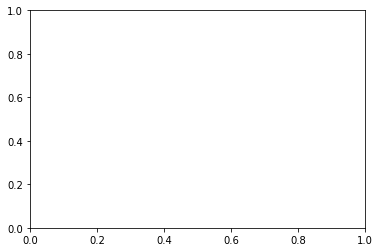

In [62]:
#data = data.set_index(['quarter', 'company']).value
#val_trends_bar_df = val_trends_bar_df.set_index(['year', 'quarter']).value
fig, ax = plt.subplots()

ax.plot(val_trends_bar_df.index(level=1), val_trends_bar_df.BnB, 'b', label='BnB')
ax.set_ylabel('Variance of log wages')

ax2 = ax.twinx()
ax2.plot(val_trends_bar_df.index(level=1), val_trends_bar_df.Total, 'g' , label='Total')
ax2.set_ylabel('Average age')

lines = ax.get_lines() + ax2.get_lines()
ax.legend(lines, [line.get_label() for line in lines], loc='upper center')

ax.set_title('Wage Variance and Mean Age')
plt.show()

In [42]:
only_bnb_df = sap_df[sap_df['Bnb_flag'] == 'BnB'].copy()
val_trends_multi = round(only_bnb_df.groupby(['year', 'quarter'])['Val_USD'].sum() / 1000000, 1)
val_trends_multi['cumupct'] = val_trends_multi.groupby(level=-1).cumsum()/val_trends_multi.groupby(level=-1).sum()*100
val_trends_multi.head()

#combined_df.groupby(level=-1)['cost'].cumsum()
#only_bnb_df.head(2)
# val_trends_multi = sap_df.groupby(['year', 'quarter', 'Bnb_flag'])['Val_USD'].sum()
# df["cumpercentage"] = df["country"].cumsum()/df["country"].sum()*100

year  quarter
2018  1          31.9
      2          29.5
      3          36.5
      4          68.6
2019  1          82.9
Name: Val_USD, dtype: object

TypeError: unsupported operand type(s) for -: 'tuple' and 'float'

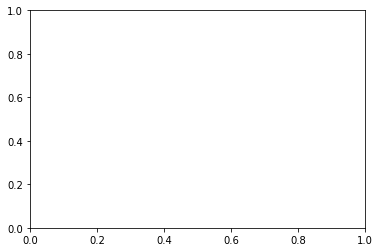

In [54]:
# val_trends_bar = sap_df.groupby(['year', 'quarter', 'Bnb_flag'])['Val_USD'].sum() / 1000000
# val_trends_bar_df = val_trends_bar.unstack('Bnb_flag')

# mkt_df = round(100 * sap_df.groupby(['BMC Market'])['Bnb_flag'].value_counts(normalize=True)).unstack()

#val_trends_bar_df = val_trends_bar.unstack('Bnb_flag')

#df = df.sort_values(by='country',ascending=False)
width=0.35
fig, ax = plt.subplots()

ax.bar(val_trends_bar_df.index, val_trends_bar_df["BnB"], color="C0", label='BnB')
# ax2 = ax.twinx()
# ax2.plot(mkt_df.index, mkt_df["Non_BnB"], color="C1", marker="D", ms=7, label='Non BnB')
# ax.yaxis.set_major_formatter(PercentFormatter())
# ax2.yaxis.set_major_formatter(PercentFormatter())

# ax.tick_params(axis="y", colors="C0")
# ax2.tick_params(axis="y", colors="C1")
# ax.set_xticks(range(len(mkt_df)))
# ax.set_xticklabels([item for item in mkt_df.index.tolist()], rotation=90);
ax.legend()
#ax2.legend()
plt.title("Pareto Bnb by Market")
plt.xlabel('Market')
plt.show()

In [ ]:
sap_df_plot = round(100 * sap_df.groupby(['year','quarter'])['Bnb_flag'].value_counts(normalize=True))
plot_df = sap_df_plot.unstack('Bnb_flag')

ax = plot_df.plot()
ax.set_xticks(range(len(plot_df)));
ax.set_xticklabels([item for item in plot_df.index.tolist()], rotation=90);

plt.title('BnB vs Non BnB - 2017 to 2019')
plt.xlabel('Year, Quarter')
plt.ylabel('Percentage')

#### Trend by Markets

In [ ]:
sap_mkts = sap_df.groupby('BMC Market')
for key, group in sap_mkts:
    mkt_df = round(100 * group.groupby(['year','quarter'])['Bnb_flag'].value_counts(normalize=True))
    plt_mkt = mkt_df.unstack('Bnb_flag')

    ax = plt_mkt.plot()
    ax.set_xticks(range(len(plt_mkt)));
    ax.set_xticklabels([item for item in plt_mkt.index.tolist()], rotation=90);

    plt.title('BnB vs Non BnB - 2017 to 2019 -> ' + key)
    plt.xlabel('Year, Quarter')
    plt.ylabel('Percentage')

In [79]:
sap_mkts = sap_df.groupby('BMC Market')['Val_USD'].sum()
sap_mkts.head()

BMC Market
APAC              3.457146e+07
Africa            6.650189e+06
Benelux           2.559810e+07
Central Europe    1.815433e+07
DACH              5.530267e+07
Name: Val_USD, dtype: float64

In [ ]:
#mkt_df.sort_values
mkt_df = round(100 * sap_df.groupby(['BMC Market'])['Bnb_flag'].value_counts(normalize=True)).unstack()
#mkt_df.sort_values('Bnb_flag', ascending=False)
#mkt_df.sort_values(by = 'BnB', ascending=False)
#mkt_df.sort_values(['BnB', 'Non_BnB'])
#df = df.reindex_axis(sorted(df.columns, reverse=True), axis=1)
mkt_df = mkt_df.sorted(mkt_df['BnB'], reverse=True)
mkt_df.head()

In [ ]:
df = pd.DataFrame({'country': [177.0, 7.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0]})
df.index = ['USA', 'Canada', 'Russia', 'UK', 'Belgium', 'Mexico', 'Germany', 'Denmark']
df = df.sort_values(by='country',ascending=False)
df["cumpercentage"] = df["country"].cumsum()/df["country"].sum()*100
df

#### Pareto Chart

In [ ]:
mkt_df = round(100 * sap_df.groupby(['BMC Market'])['Bnb_flag'].value_counts(normalize=True)).unstack()
#df = df.sort_values(by='country',ascending=False)
fig, ax = plt.subplots()

ax.bar(mkt_df.index, mkt_df["BnB"], color="C0", label='BnB')
ax2 = ax.twinx()
ax2.plot(mkt_df.index, mkt_df["Non_BnB"], color="C1", marker="D", ms=7, label='Non BnB')
ax.yaxis.set_major_formatter(PercentFormatter())
ax2.yaxis.set_major_formatter(PercentFormatter())

ax.tick_params(axis="y", colors="C0")
ax2.tick_params(axis="y", colors="C1")
ax.set_xticks(range(len(mkt_df)))
ax.set_xticklabels([item for item in mkt_df.index.tolist()], rotation=90);
ax.legend()
ax2.legend()
plt.title("Pareto Bnb by Market")
plt.xlabel('Market')
plt.show()

In [ ]:
df = pd.DataFrame({'country': [177.0, 7.0, 4.0, 2.0, 2.0, 1.0, 1.0, 1.0]})
df.index = ['USA', 'Canada', 'Russia', 'UK', 'Belgium', 'Mexico', 'Germany', 'Denmark']
df = df.sort_values(by='country',ascending=False)
df["cumpercentage"] = df["country"].cumsum()/df["country"].sum()*100
df

### Section 2 - Exploring BnB data subset

In [ ]:
bnb_df = sap_df[sap_df['Bnb_flag'] == 'BnB'].copy()

In [ ]:
bnb_df['Creation date'] = bnb_df['Creation date'].astype('datetime64[D]')
bnb_df['year'] = bnb_df['Creation date'].dt.year
bnb_df['quarter'] = bnb_df['Creation date'].dt.quarter

In [ ]:
# pct2019 = round(100 * df2019['Bnb_flag'].value_counts(normalize=True))
# sap_df.groupby('Description')['Bnb_flag'].value_counts()
bnb_df1819 = bnb_df[(bnb_df['year'] == 2018) | (bnb_df['year'] == 2019)].copy()
bnb_market = round(100 * bnb_df1819.groupby(['year', 'quarter'])['BMC Market'].value_counts(normalize=True))

In [ ]:
bnb_market = bnb_market.unstack()
bnb_market.plot()
plt.xticks()
plt.show()

In [ ]:
plt.figure()
round(100 * bnb_df1819.groupby(['year', 'quarter'])['BMC Market'].value_counts(normalize=True)).unstack().plot()
#df.groupby(['Year','Fungicide']).sum().unstack().plot()

In [ ]:

#bnb_market.plot.line()
#apple_fplot = df.groupby(['Year','Fungicide'])['Value'].sum()
plot_df = bnb_market.unstack('quarter').loc[:, 'BMC Market']
plot_df.head()
#plot_df.index = pd.PeriodIndex(plot_df.index.tolist(), freq='A')
#plot_df.plot()

In [ ]:
#df.groupby(by=[df.index.year, df.index.quarter]).mean().plot(kind='bar')
bnb_df.groupby(by=[bnb_df.year, bnb_df.quarter]).mean().plot(kind='bar')

In [ ]:
bnb_df['Year'] = dt.strptime(bnb_df['Creation date'], '%m/%d/%Y').date().year
bnb_df.head(2)

In [ ]:

prods_pct = round(100 * bnb_df['Description'].value_counts(normalize=True))
prods_pct

In [ ]:
#bnb_df = sap_df[sap_df['Bnb_flag'] == 'BnB']
test = bnb_df['Description'].value_counts()
test

In [ ]:
## BnB orders Classifying by desciption

prods_10pct = prods_pct[prods_pct>=3]

prods_10pct.plot.pie(y=prods_10pct.index,
           shadow=False,
           startangle=90,
           autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.title('Percentage of top BnB products')
plt.ylabel('')
plt.show()

In [ ]:
cust_pct = round(100 * bnb_df['Sold-to_party'].value_counts(normalize=True))
cust_pct

In [ ]:
test1 = bnb_df['Sold-to_party'].value_counts()
test1

In [ ]:
## Top customers ordering BnB
cust_pct = round(100 * bnb_df['Sold-to_party'].value_counts(normalize=True))
#cust_5pct = cust_pct[cust_pct >= 3]

cust_pct.plot.pie(y=cust_pct.index,
           shadow=False,
           startangle=90,
           autopct='%1.1f%%')

plt.axis('equal')
plt.tight_layout()
plt.title('Percentage of Top Customers ordering Bnb')
plt.ylabel('')
plt.show()

In [ ]:
mkt_pct = round(100 * bnb_df['BMC Market'].value_counts(normalize=True))
mkt_pct

In [ ]:
test2 = bnb_df['BMC Market'].value_counts()
test2

In [ ]:
mkt_pct = round(100 * bnb_df['BMC Market'].value_counts(normalize=True))
mkt_pct.plot.bar()


# cust_pct.plot.pie(y=cust_pct.index,
#            shadow=False,
#            startangle=90,
#            autopct='%1.1f%%')

#plt.tight_layout()
plt.title('Percentage of Top Markets ordering Bnb')
plt.ylabel('')

ax = mkt_pct.plot(kind='bar')
def autolabel(rects, ax):
    for rect in rects:
        x = rect.get_x() + rect.get_width()/2.
        y = rect.get_height()
        ax.annotate("{}".format(y), (x,y), xytext=(0,5), textcoords="offset points",
                    ha='center', va='bottom')

autolabel(ax.patches,ax)

ax.margins(y=0.1)
plt.show()

In [ ]:
bnbs = sap_df[sap_df['Bnb_flag'] == 'BnB']
funnels = sap_df[sap_df['Bnb_flag'] == 'Non_BnB']

set_bnb = set(bnbs['Sold-to_party'])
set_funnel = set(funnels['Sold-to_party'])

In [ ]:
intersec = set_bnb.intersection(set_funnel)
print("Customers who order both BnB and Funnel " + str(len(intersec)))
only_bnb = set_bnb.difference(set_funnel)
print("Customers who only order BnB " + str(len(only_bnb)))
only_funnel = set_funnel.difference(set_bnb)
print("Customers who order only Funnel " + str(len(only_funnel)))
total = set_bnb.union(set_funnel)
print("Total unique customers " + str(len(total)))

In [ ]:
# venn3([set1, set2, set3], ('Set1', 'Set2', 'Set3'))

venn2([set_bnb, set_funnel], ('BnB', 'Non BnB'))
plt.show()

In [ ]:
bnbs = sap_df[sap_df['Bnb_flag'] == 'BnB']
funnels = sap_df[sap_df['Bnb_flag'] == 'Non_BnB']

set_bnb_prod = set(bnbs['Description'])
set_funnel_prod = set(funnels['Description'])


intersec1 = set_bnb_prod.intersection(set_funnel_prod)
print("Products which are under both BnB and Funnel " + str(len(intersec1)))
only_bnb1 = set_bnb_prod.difference(set_funnel_prod)
print("Products which are only order BnB " + str(len(only_bnb1)))
only_funnel1 = set_funnel_prod.difference(set_bnb_prod)
print("Products which are only Funnel " + str(len(only_funnel1)))
total1 = set_bnb_prod.union(set_funnel_prod)
print("Total unique products " + str(len(total1)))

------------------------------------------------------------------------------------
#### Work in progress

In [ ]:
sap_df.groupby('Description')['Bnb_flag'].value_counts()

In [ ]:
sap_df.groupby('Sold-to_party')['Bnb_flag'].value_counts()

In [ ]:
sap_df['Sold-to_party'].value_counts()

In [ ]:
by_val = bnb_df.groupby('Description')['Val_USD'].sum()
val_50k = by_val[by_val >= 50000]

val_50k

In [ ]:
val_50k.plot.bar()

In [ ]:
## Save file
path = r"C:\Users\320054667\OneDrive - Philips\Work\Project\UltraSound\BookNBill\Tagged1819.xlsx"
writer = pd.ExcelWriter(path, engine='xlsxwriter')
sap_df.to_excel(writer, sheet_name='Sheet1')
writer.save()
writer.close()

In [72]:
sap_df.head()

,BMC Market,Comp_code_Sales,Country,Sold-to_party,Description,Sales order,First Fin Bill Date,Local Currency,Creation date,Total OIT Value (DC),Bnb_flag,System,Category,USD,Val_USD,year,quarter
0,Africa,H0_EG90,EGYPT LLC,???? ????? ????????,AFFINITI 50 ULTRASOUND SYSTEM,H0_6600378541,5/2/2018,USD,2018-01-31,48000.0,Non_BnB,System,Affiniti,1.000000,48000.0,2018,1
2,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,AFFINITI 70 UPGRADE,H0_6600376874,3/29/2018,ZAR,2018-01-22,196240.0,BnB,Upgrade,Affiniti,0.069324,13736.8,2018,1
3,Africa,H0_ZA91,SOUTH AFRICA,Life Healthcare Group t/a Rosepark,CLEARVUE 650 ULTRASOUND SYSTEM,H0_6600380813,3/29/2018,ZAR,2018-01-29,278000.0,BnB,System,Clearvue,0.069324,19460.0,2018,1
4,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,QLAB,H0_6600376873,2/28/2018,ZAR,2018-01-22,23460.0,BnB,Others,Others,0.069324,1642.2,2018,1
5,Africa,H0_ZA91,SOUTH AFRICA,Netcare St. Anne's Hospital,CX50 ULTRASOUND SYSTEM,H0_6600376873,2/28/2018,ZAR,2018-01-22,725010.0,BnB,System,CX50,0.069324,50750.7,2018,1


In [73]:
## Save file
path = r"C:\Users\320054667\OneDrive - Philips\Work\Project\UltraSound\BookNBill\Classified_bnb.xlsx"
writer = pd.ExcelWriter(path, engine='xlsxwriter')
sap_df.to_excel(writer, sheet_name='Sheet1')
writer.save()
writer.close()

In [ ]:
from IPython.core.magic import register_line_magic

@register_line_magic
def pip(args):
    """Use pip from the current kernel"""
    from pip import main
    main(args.split())

In [ ]:
%pip install %matplotlib_venn

In [ ]:
!pip install matplotlib-venn